# **Livrable 4  : Modélisation numérique**  

## **Contexte :** 

Votre POC permettra de réaliser toutes les étapes de transformation d'un message pour qu'il soit envoyé. La phase d'émission se terminera par la lecture du son généré (celui qui serait créé par le pad de l'agent). Dans une seconde phase, votre POC simulera la réception du signal. Cette phase contiendra toutes les étapes de transformation afin de reconstruire le message d'origine.

Pour être recevable, votre POC devra parfaitement reconstituer l'ensemble de la chaîne de transmission sur n'importe quelle entrée de type texte (5 à 10 caractères). Dans cette version de base, le mode de communication sera le mode simplex. Le signal à la réception ne sera pas bruité. Le message sera décomposé en trames et votre prototype intégrera un système de détection d'erreur.

Les étapes seront bien identifiées dans des codes séparés au niveau du notebook et avec tous les commentaires nécessaires. Votre code génèrera à chaque étape une sortie permettant de visualiser et valider le bon déroulé de l'étape. (livrable niveau B)

Pour vraiment impressionner le comité de pilotage (livrable niveau A), vous devrez intégrer 2 fonctionnalités supplémentaires parmi :

* l'envoi et la reconstitution d'un message de type son

* la gestion de la réception d'un signal avec bruit

* l'utilisation d'une liaison half duplex (accusé de réception)

* un CRC ou un code de correction d'erreur

* la simulation entre 2 PC (l'un pour la génération du son correspondant au message à envoyer, l'autre pour la réception et la reconstruction du message)

* la mise en œuvre d'un second type de modulation/démodulation


## **Le but du livrable :** 

Ayant désormais la vision complète de la chaîne de transmission pour réaliser la communication, vous devez mettre en place un prototype pour faire la démonstration de la viabilité de votre solution.

### **I. Code complet sans explication** 

Message ASCII : [108, 97, 108, 97]
Message binaire : 01101100011000010110110001100001
Trame générée : 10101010011011000110000101101100011000010000000011111111


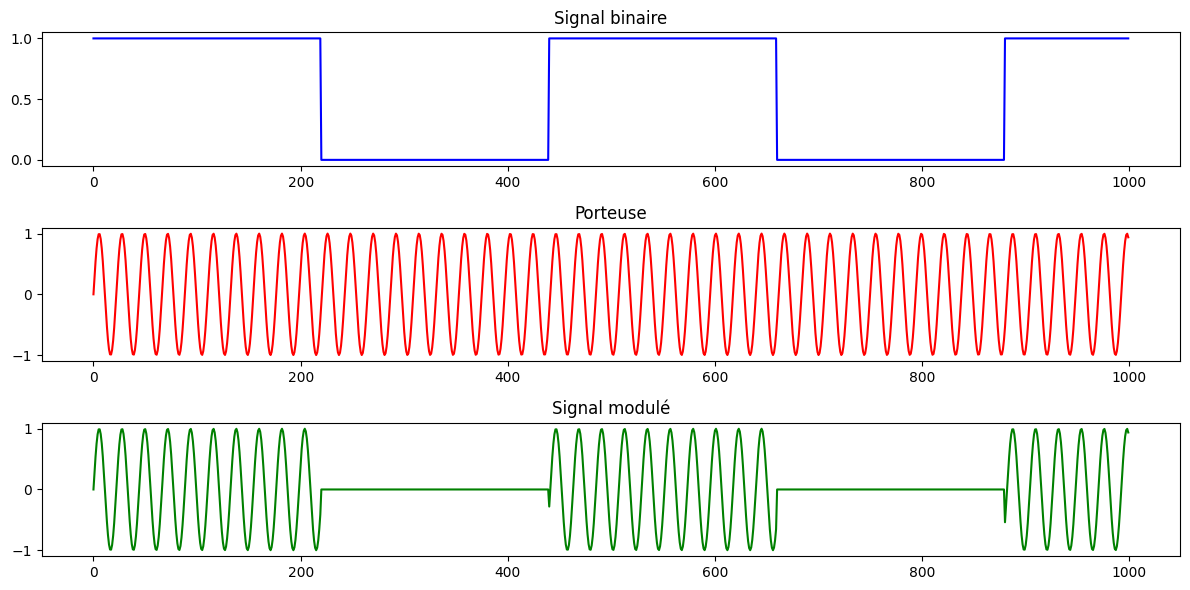

Transmission #1
Erreur de réception par bit :  [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
✅ Pas d'erreur de réception!
Message reçu : ªlala ÿ


C:\Users\voste\AppData\Local\Temp\ipykernel_16996\4290494339.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y.append(np.trapz(produit[i:i+Ns], t[i:i+Ns]))


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de modulation
Ns = 220  # Nombre d'échantillons par bit (peut être ajusté)
Fp = 2000  # Fréquence de la porteuse (peut être ajusté)
Fe = 44100

# Conversion texte en ASCII puis en binaire
def text_to_ascii(text):
    return [ord(c) for c in text]

def ascii_to_binary(ascii_list):
    return ''.join(format(num, '08b') for num in ascii_list)

# Calcul du CRC-8 simplifié (somme XOR des octets du message)
def calculate_crc8_simple(binary_message):
    crc = 0x00  # CRC initialisé à 0

    # Convertir la chaîne binaire en octets (8 bits)
    byte_array = [int(binary_message[i:i+8], 2) for i in range(0, len(binary_message), 8)]

    # XOR sur tous les octets du message
    for byte in byte_array:
        crc ^= byte  # XOR avec l'octet actuel

    return format(crc, '08b')  # Retourner le CRC sous forme binaire (8 bits)

# Génération de la trame avec CRC simplifié
def create_frame(binary_message):
    preamble = "10101010"  # Préambule (synchronisation)
    crc = calculate_crc8_simple(binary_message)  # CRC simplifié
    end_frame = "11111111"  # Fin de trame

    return f"{preamble}{binary_message}{crc}{end_frame}"

# Modulation ASK
def binary_to_ask(binary_seq, Ns):
    ASK_signal = []
    for bit in binary_seq:
        symbol = [1 if bit == '1' else 0] * Ns
        ASK_signal.extend(symbol)
    return np.array(ASK_signal)

# Démodulation ASK
def ask_demodulation(ASK_signal, Fe, Fp, Ns):
    t = np.arange(len(ASK_signal)) / Fe
    porteuse = np.sin(2 * np.pi * Fp * t)  # Porteuse
    produit = ASK_signal * porteuse  # Multiplication par la porteuse

    y = []  # Résultat de l'intégration par période
    for i in range(0, len(ASK_signal), Ns):
        y.append(np.trapz(produit[i:i+Ns], t[i:i+Ns]))
    return np.array(y)

# Vérification du CRC à la réception
def check_crc(binary_message_with_crc):
    preamble_length = 8
    end_frame_length = 8
    crc_length = 8

    # Extraction des parties
    binary_message = binary_message_with_crc[preamble_length:-end_frame_length-crc_length]
    received_crc = binary_message_with_crc[-end_frame_length-crc_length:-end_frame_length]

    # Recalcul du CRC
    calculated_crc = calculate_crc8_simple(binary_message)

    return received_crc == calculated_crc  # Retourne True si le CRC est correct

# Fonction pour convertir un message binaire en ASCII
def binary_to_ascii(binary_message):
    binary_values = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]
    return ''.join(ascii_characters)

# Simulation de la réception avec détection d'erreurs et retransmission si nécessaire
def simulate_reception(frame):
    # Tentatives de transmission
    retry_limit = 3
    retry_count = 0
    while retry_count < retry_limit:
        print(f"Transmission #{retry_count + 1}")
        
        # Génération du signal ASK
        ASK_signal = binary_to_ask(frame, Ns)
        t_ask = np.arange(len(ASK_signal)) / Fe  # Axe des temps
        porteuse = np.sin(2 * np.pi * Fp * t_ask)  # Porteuse
        modulated_signal = ASK_signal * porteuse  # Signal modulé

        # Démodulation
        demodulated_signal = ask_demodulation(modulated_signal, Fe, Fp, Ns)
        
        # Conversion du signal démodulé en binaire (en fonction du seuil)
        demodulated_binary_message = ''.join(['1' if val > 0 else '0' for val in demodulated_signal])
        
        # Comparaison bit par bit
        errors = [frame[i] != demodulated_binary_message[i] for i in range(len(frame))]
        print("Erreur de réception par bit : ", errors)  # Affiche les erreurs bit par bit
        
        # Vérification du CRC
        if check_crc(demodulated_binary_message):
            print("✅ Pas d'erreur de réception!")
            decoded_message = binary_to_ascii(demodulated_binary_message)
            print(f"Message reçu : {decoded_message}")
            break
        else:
            print("❌ Erreur de réception détectée! Nouvelle tentative...")
            retry_count += 1
        
    if retry_count == retry_limit:
        print("❗ Limite de retransmissions atteinte. Échec de la réception.")
        return None

# Demande à l'utilisateur un message à moduler
message = input("Entrez le message à moduler: ")

# Conversion du message en binaire
ascii_message = text_to_ascii(message)
binary_message = ascii_to_binary(ascii_message)
print(f"Message ASCII : {ascii_message}")
print(f"Message binaire : {binary_message}")

# Création de la trame (avec préambule, CRC et fin de trame)
frame = create_frame(binary_message)
print(f"Trame générée : {frame}")

# Affichage des courbes du signal
ASK_signal = binary_to_ask(frame, Ns)
t_ask = np.arange(len(ASK_signal)) / Fe  # Axe des temps
porteuse = np.sin(2 * np.pi * Fp * t_ask)  # Porteuse
modulated_signal = ASK_signal * porteuse  # Signal modulé

# Affichage des signaux
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title("Signal binaire")
plt.plot(ASK_signal[:1000], 'b')
plt.subplot(3, 1, 2)
plt.title("Porteuse")
plt.plot(porteuse[:1000], 'r')
plt.subplot(3, 1, 3)
plt.title("Signal modulé")
plt.plot(modulated_signal[:1000], 'g')
plt.tight_layout()
plt.show()

# Simulation de la réception et détection d'erreurs
received_message = simulate_reception(frame)

# Si un message est reçu sans erreur, on peut afficher le résultat
if received_message:
    print(f"Le message reçu est : {received_message}")

## **II. Code avec explication :**

### **1. Importation des bibliothèques**

In [ ]:
import numpy as np => Pour les nombres tel que pi, sin ou cos car ils ne sont pas importé initialement dans le code
import matplotlib.pyplot as plt => Pour la représentation graphique des signaux

### **2. Paramètre de modulation**

In [ ]:
Ns = 220 => Le nombre d'échantillons par bit. Plus il est élevé, plus le signal sera précis mais prendra plus de place.
Fp = 2000  => Fréquence de la porteuse en HZ
Fe = 44100  => Fréquence d'échantillonnage (standard pour l'audio)

### **3. Conversion du texte en binaire**

In [ ]:
def text_to_ascii(text):
    return [ord(c) for c in text]

Cette fonction transforme chaque caractère du texte en son code ASCII

#def text_to_ascii(text):
Définit une fonction appelée text_to_ascii qui prend en entrée une chaîne de caractères text.

#return [ord(c) for c in text]
Utilise une compréhension de liste pour parcourir chaque caractère c de text.
ord(c): Convertit le caractère en son code ASCII (nombre entier).
Retourne une liste de nombres ASCII.

def ascii_to_binary(ascii_list):
    return ''.join(format(num, '08b') for num in ascii_list)

Cette fonction permet de convertir chaque caractère ASCII en binaire sur 8 bits

#def ascii_to_binary(ascii_list):
Définit une fonction appelée ascii_to_binary qui prend une liste de nombres ASCII en entrée.

#return ''.join(format(num, '08b') for num in ascii_list)
format(num, '08b') :
Convertit num (nombre ASCII) en binaire sur 8 bits ('08b' signifie 8 bits avec des 0 au début si nécessaire).

for num in ascii_list :
Parcourt chaque nombre dans la liste ASCII.

''.join(...) :
Concatène tous les morceaux binaires en une seule chaîne.

Exemple : 

* Texte : "Hi"
* ASCII : [72, 105]
* Binaire : "0100100001101001"

### **4. Génération du CRC-8 simplifié**

In [ ]:
def calculate_crc8_simple(binary_message):
    crc = 0x00  # CRC initialisé à 0
    byte_array = [int(binary_message[i:i+8], 2) for i in range(0, len(binary_message), 8)]
    for byte in byte_array:
        crc ^= byte  # XOR avec chaque octet
    return format(crc, '08b')  # Retourne le CRC en binaire

Le CRC (Cyclic Redundancy Check) est une somme XOR de tous les octets du message. Il permet de détecter les erreurs de transmission.

#def calculate_crc8_simple(binary_message):
Définit une fonction appelée calculate_crc8_simple.
Elle prend en entrée binary_message, une chaîne de caractères contenant une suite de bits ('01001000...').

#crc = 0x00  # CRC initialisé à 0
crc est initialisé à 0x00 (soit 00000000 en binaire).
Ce sera notre valeur de départ pour le calcul du CRC

#byte_array = [int(binary_message[i:i+8], 2) for i in range(0, len(binary_message), 8)]
On veut traiter le message par groupes de 8 bits (1 octet).

#binary_message[i:i+8] :
Sélectionne 8 bits à la fois (ex : "01001000", "01101001", etc.).

#int(..., 2) :
Convertit cette chaîne binaire en un nombre entier.

#[ ... for i in range(0, len(binary_message), 8)] :
Parcourt toute la chaîne et crée une liste d'octets.

#for byte in byte_array:
    crc ^= byte  # XOR avec l'octet actuel

#for byte in byte_array: :
Parcourt chaque octet du message.

#crc ^= byte :
Applique un XOR bit à bit entre crc et l’octet actuel.

#format(crc, '08b') :
Convertit crc en chaîne binaire sur 8 bits.

#return ... :
Renvoie la valeur finale du CRC.

Exemple

* Message binaire : "0100100001101001"
* CRC calculé : "10110011"

### **5. Création de la trame de transmission**

In [ ]:
def create_frame(binary_message):
    preamble = "10101010"  # Préambule pour la synchronisation
    crc = calculate_crc8_simple(binary_message)  # CRC
    end_frame = "11111111"  # Indicateur de fin de trame
    return f"{preamble}{binary_message}{crc}{end_frame}"

La trame de transmission est constituée de :

* Un préambule "10101010" pour aider à la synchronisation.
* Le message binaire.
* Le CRC pour la détection d’erreurs.
* Une fin de trame "11111111" pour signaler la fin du message.

#def create_frame(binary_message):
Définit une fonction appelée create_frame.
Elle prend en entrée binary_message, qui est une chaîne de bits (ex: "0100100001101001...").

#preamble = "10101010"  # Préambule (synchronisation)
Le préambule est une séquence fixe : "10101010".
Il sert à synchroniser le récepteur avant la transmission du message.
Ce motif est souvent utilisé car il alterne 1 et 0, ce qui permet au récepteur de détecter facilement le début du message.

#crc = calculate_crc8_simple(binary_message)  # CRC simplifié
On appelle la fonction calculate_crc8_simple() (vue dans la partie précédente).
Elle calcule le CRC sur le message binaire.
Le CRC est utilisé pour détecter les erreurs à la réception.

#end_frame = "11111111"  # Fin de trame
"11111111" est un marqueur spécial indiquant la fin de la transmission.
Le récepteur sait ainsi que le message est terminé.

#return f"{preamble}{binary_message}{crc}{end_frame}"
Concatène toutes les parties pour former la trame complète :
préambule + message + CRC + fin de trame
La trame est donc une longue chaîne de bits prête à être transmise

### **6. Modulation ASK** 

In [ ]:
def binary_to_ask(binary_seq, Ns):
    ASK_signal = []
    for bit in binary_seq:
        symbol = [1 if bit == '1' else 0] * Ns  # Convertit chaque bit en un signal de Ns échantillons
        ASK_signal.extend(symbol)
    return np.array(ASK_signal)

ASK signifie Amplitude Shift Keying, une modulation d’amplitude.

Un bit "1" est représenté par une onde à 1.
Un bit "0" est représenté par une onde à 0.

#def binary_to_ask(binary_seq, Ns):
Définit une fonction appelée binary_to_ask.
Entrées :
binary_seq : une chaîne binaire ('101010...').
Ns : le nombre d'échantillons par bit (détermine la durée d’un bit).

#ASK_signal = []
On crée une liste vide qui contiendra le signal modulé en ASK.

#for bit in binary_seq:
On parcourt chaque bit du message.

#symbol = [1 if bit == '1' else 0] * Ns
Si le bit est 1, on crée une séquence de Ns valeurs égales à 1.
Si le bit est 0, on crée une séquence de Ns valeurs égales à 0.
Cela permet de convertir chaque bit en une séquence continue.

#ASK_signal.extend(symbol)
Ajoute la séquence calculée (symbol) à ASK_signal.

#return np.array(ASK_signal)
Convertit ASK_signal en un tableau NumPy (permet une manipulation efficace des données pour l'affichage et le traitement).
                                          



### **7. Démodulation ASK**

In [ ]:
def ask_demodulation(ASK_signal, Fe, Fp, Ns):
    t = np.arange(len(ASK_signal)) / Fe  # Temps
    porteuse = np.sin(2 * np.pi * Fp * t)  # Génération de la porteuse
    produit = ASK_signal * porteuse  # Multiplication du signal par la porteuse

    y = []  # Intégration sur chaque période
    for i in range(0, len(ASK_signal), Ns):
        y.append(np.trapz(produit[i:i+Ns], t[i:i+Ns]))
    return np.array(y)

Cette fonction extrait l’information du signal modulé en détectant l’amplitude.

#def ask_demodulation(ASK_signal, Fe, Fp, Ns):
Définit une fonction appelée ask_demodulation.
Entrées :
ASK_signal : Le signal modulé en ASK reçu.
Fe : La fréquence d’échantillonnage (nombre d’échantillons par seconde).
Fp : La fréquence de la porteuse.
Ns : Le nombre d’échantillons par bit.

#t = np.arange(len(ASK_signal)) / Fe
Crée un tableau de temps t correspondant aux instants d'échantillonnage.
len(ASK_signal) / Fe permet d’obtenir le temps total.

#porteuse = np.sin(2 * np.pi * Fp * t)  # Porteuse
Crée une onde sinusoïdale à la fréquence Fp.
Cette onde est identique à celle utilisée pour la modulation.

#produit = ASK_signal * porteuse  # Multiplication par la porteuse
Multiplie échantillon par échantillon le signal ASK_signal par porteuse.
Cette étape ramène le signal autour de zéro pour pouvoir extraire l'information binaire.

#y = []  # Résultat de l'intégration par période
On crée une liste vide y pour stocker les valeurs après intégration.

#for i in range(0, len(ASK_signal), Ns):
Parcourt le signal par tranches de Ns échantillons (correspondant à un bit).

#y.append(np.trapz(produit[i:i+Ns], t[i:i+Ns]))
np.trapz() applique la méthode des trapèzes pour intégrer produit sur la durée d’un bit (Ns échantillons).
L'intégration donne une valeur élevée pour un "1" et proche de zéro pour un "0".

#return np.array(y)
Convertit y en tableau NumPy pour faciliter l’analyse

### **8. Vérification du CRC**

In [ ]:
def check_crc(binary_message_with_crc):
    preamble_length = 8
    end_frame_length = 8
    crc_length = 8
    binary_message = binary_message_with_crc[preamble_length:-end_frame_length-crc_length]
    received_crc = binary_message_with_crc[-end_frame_length-crc_length:-end_frame_length]
    calculated_crc = calculate_crc8_simple(binary_message)
    return received_crc == calculated_crc

Cette fonction extrait le message reçu et le CRC, puis le compare avec le CRC recalculé.

#def check_crc(binary_message_with_crc):
Définit une fonction appelée check_crc.
Entrée :
binary_message_with_crc : message binaire complet reçu, y compris le préambule, le message, le CRC et la fin de trame.
Sortie :
True si le CRC est correct (aucune erreur détectée).
False si le CRC ne correspond pas (erreur détectée)

#preamble_length = 8
#end_frame_length = 8
#crc_length = 8
Définit les longueurs des différentes parties du message :
Préambule (8 bits) → utilisé pour la synchronisation.
Fin de trame (8 bits) → indique la fin de la transmission.
CRC (8 bits) → permet de vérifier l’intégrité des données.

#binary_message = binary_message_with_crc[preamble_length:-end_frame_length-crc_length]
Extrait le message binaire réel (sans le préambule, le CRC et la fin de trame).
Explication de l'indexation :
preamble_length: → Supprime le préambule au début.
:-end_frame_length-crc_length → Supprime la fin de trame et le CRC à la fin.

#received_crc = binary_message_with_crc[-end_frame_length-crc_length:-end_frame_length]
Extrait le CRC reçu du message complet.
Il se trouve juste avant la fin de trame.

#calculated_crc = calculate_crc8_simple(binary_message)
Recalcule le CRC du message extrait en utilisant la même fonction calculate_crc8_simple().
Si calculate_crc8_simple("01100001 01100010 01100011") donne "11110000", cela signifie que le message est correct.

#return received_crc == calculated_crc
Si les deux valeurs sont identiques → Pas d’erreur (True).
Si les deux valeurs sont différentes → Il y a eu une erreur de transmission (False).


### **9. Conversion du binaire en ASCII**

In [ ]:

def binary_to_ascii(binary_message):
    binary_values = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
    ascii_characters = [chr(int(bv, 2)) for bv in binary_values]
    return ''.join(ascii_characters)

Elle convertit le binaire en caractères ASCII.

#def binary_to_ascii(binary_message):
Définit une fonction appelée binary_to_ascii.
Entrée :
binary_message : Une chaîne binaire représentant un message.
Sortie :
Une chaîne de caractères ASCII lisible.

#binary_values = [binary_message[i:i+8] for i in range(0, len(binary_message), 8)]
Coupe binary_message en groupes de 8 bits (chaque caractère ASCII = 8 bits).
Utilise une compréhension de liste :
for i in range(0, len(binary_message), 8) → Parcourt la chaîne en sautant 8 par 8.
binary_message[i:i+8] → Extrait chaque groupe de 8 bits.

#ascii_characters = [chr(int(bv, 2)) for bv in binary_values]
Convertit chaque groupe de 8 bits en décimal avec int(bv, 2).
Convertit ensuite ce nombre en caractère ASCII avec chr().
Utilise une compréhension de liste pour stocker tous les caractères.

#return ''.join(ascii_characters)
Fusionne tous les caractères ASCII en une seule chaîne avec ''.join().


### **10. Simulation de la transmission et détections d'erreurs**

In [ ]:
def simulate_reception(frame):
    retry_limit = 3
    retry_count = 0
    while retry_count < retry_limit:
        print(f"Transmission #{retry_count + 1}")
        
        ASK_signal = binary_to_ask(frame, Ns)
        t_ask = np.arange(len(ASK_signal)) / Fe
        porteuse = np.sin(2 * np.pi * Fp * t_ask)
        modulated_signal = ASK_signal * porteuse  

        demodulated_signal = ask_demodulation(modulated_signal, Fe, Fp, Ns)
        demodulated_binary_message = ''.join(['1' if val > 0 else '0' for val in demodulated_signal])
        
        errors = [frame[i] != demodulated_binary_message[i] for i in range(len(frame))]
        print("Erreur de réception par bit : ", errors)
        
        if check_crc(demodulated_binary_message):
            print("Pas d'erreur de réception!")
            decoded_message = binary_to_ascii(demodulated_binary_message)
            print(f"Message reçu : {decoded_message}")
            break
        else:
            print("Erreur de réception détectée! Nouvelle tentative...")
            retry_count += 1
        
    if retry_count == retry_limit:
        print("Limite de retransmissions atteinte. Échec de la réception.")
        return None

Cette fonction simule la transmission/réception :

1. Convertit le message en signal ASK.
2. Démodule le signal.
3. Vérifie s’il y a des erreurs grâce au CRC.
4. Si le message est corrompu, il retransmet jusqu'à 3 fois.

#def simulate_reception(frame):
Définit une fonction simulate_reception.
Entrée :
frame : Message binaire complet à transmettre.
Sortie :
Affiche le message reçu s'il est correct.
Sinon, retransmet jusqu'à 3 fois avant d'abandonner.

#retry_limit = 3
"retry_count = 0
retry_limit = 3 : Nombre maximum de tentatives de retransmission.
retry_count = 0 : Compteur d’essais.

#while retry_count < retry_limit:
Tant qu'on n'a pas dépassé 3 tentatives, on recommence la transmission.

#print(f"Transmission #{retry_count + 1}")
Affiche le numéro de la tentative en cours.

#ASK_signal = binary_to_ask(frame, Ns)
Convertit frame (message binaire) en un signal modulé ASK.

#t_ask = np.arange(len(ASK_signal)) / Fe
Crée un axe des temps t_ask, en fonction de la fréquence d'échantillonnage Fe.

#porteuse = np.sin(2 * np.pi * Fp * t_ask)
Génère une onde sinusoïdale (porteuse) à la fréquence Fp.

#modulated_signal = ASK_signal * porteuse
Multiplie le signal binaire par la porteuse pour obtenir le signal ASK modulé.

#demodulated_signal = ask_demodulation(modulated_signal, Fe, Fp, Ns)
Passe le signal modulé dans la fonction ask_demodulation() pour récupérer les valeurs démodulées.

#demodulated_binary_message = ''.join(['1' if val > 0 else '0' for val in demodulated_signal])
Convertit les valeurs démodulées en bits ('1' si positif, '0' sinon).

#errors = [frame[i] != demodulated_binary_message[i] for i in range(len(frame))]
#print("Erreur de réception par bit : ", errors)
Compare chaque bit du message envoyé et reçu.
Affiche une liste d’erreurs (True si erreur, False sinon).

#if check_crc(demodulated_binary_message):
Vérifie si le CRC du message reçu est correct.

#print("✅ Pas d'erreur de réception!")
#decoded_message = binary_to_ascii(demodulated_binary_message)
#print(f"Message reçu : {decoded_message}")
#break
Si le CRC est valide, alors :
Affiche "✅ Pas d'erreur de réception!".
Convertit le message reçu en ASCII.
Affiche le message.
Arrête la transmission (break).

#else:
    #print("❌ Erreur de réception détectée! Nouvelle tentative...")
    #retry_count += 1
Si erreur détectée, affiche "❌ Erreur de réception détectée!" et réessaie.

#if retry_count == retry_limit:
    #print("❗ Limite de retransmissions atteinte. Échec de la réception.")
    #return None
Après 3 échecs, affiche "❗ Limite de retransmissions atteinte. Échec de la réception.".
Retourne None (pas de message reçu).





### **11. Execution du programme**

In [ ]:
message = input("Entrez le message à moduler: ")

ascii_message = text_to_ascii(message)
binary_message = ascii_to_binary(ascii_message)
print(f"Message ASCII : {ascii_message}")
print(f"Message binaire : {binary_message}")

frame = create_frame(binary_message)
print(f"Trame générée : {frame}")

1. L'utilisateur entre un message.
2. Il est converti en binaire et encapsulé dans une trame.

ASK_signal = binary_to_ask(frame, Ns)
t_ask = np.arange(len(ASK_signal)) / Fe
porteuse = np.sin(2 * np.pi * Fp * t_ask)
modulated_signal = ASK_signal * porteuse

Génère et affiche les signaux.

received_message = simulate_reception(frame)

if received_message:
    print(f"Le message reçu est : {received_message}")

# Affichage des courbes du signal
ASK_signal = binary_to_ask(frame, Ns)
t_ask = np.arange(len(ASK_signal)) / Fe  # Axe des temps
porteuse = np.sin(2 * np.pi * Fp * t_ask)  # Porteuse
modulated_signal = ASK_signal * porteuse  # Signal modulé

# Affichage des signaux
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title("Signal binaire")
plt.plot(ASK_signal[:1000], 'b')
plt.subplot(3, 1, 2)
plt.title("Porteuse")
plt.plot(porteuse[:1000], 'r')
plt.subplot(3, 1, 3)
plt.title("Signal modulé")
plt.plot(modulated_signal[:1000], 'g')
plt.tight_layout()
plt.show()

# Simulation de la réception et détection d'erreurs
received_message = simulate_reception(frame)

# Si un message est reçu sans erreur, on peut afficher le résultat
if received_message:
    print(f"Le message reçu est : {received_message}")

Simule la transmission et affiche le message reçu.

#message = input("Entrez le message à moduler: ")
Attend que l'utilisateur saisisse un texte.
Stocke la saisie dans message.

#text_to_ascii(message) :
Convertit chaque caractère en son code ASCII.

#ascii_to_binary(ascii_message) :
Convertit chaque code ASCII en binaire (8 bits).

#print(f"Message ASCII : {ascii_message}")
#print(f"Message binaire : {binary_message}")
Affiche les valeurs ASCII et le message en binaire.

#frame = create_frame(binary_message)
#print(f"Trame générée : {frame}")
Ajoute un préambule (10101010).
Calcule et ajoute le CRC (8 bits).
Ajoute un marqueur de fin de trame (11111111).

#ASK_signal = binary_to_ask(frame, Ns)
#t_ask = np.arange(len(ASK_signal)) / Fe  # Axe des temps
#porteuse = np.sin(2 * np.pi * Fp * t_ask)  # Porteuse
#modulated_signal = ASK_signal * porteuse  # Signal modulé
binary_to_ask(frame, Ns) : Convertit frame en un signal binaire.
t_ask = np.arange(len(ASK_signal)) / Fe : Génère l’axe des temps.
porteuse = sin(2π Fp t_ask) : Crée une onde sinusoïdale (Fp Hz).
modulated_signal = ASK_signal * porteuse : Multiplie pour obtenir le signal ASK modulé.

#plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#plt.title("Signal binaire")
#plt.plot(ASK_signal[:1000], 'b')
#plt.subplot(3, 1, 2)
#plt.title("Porteuse")
#plt.plot(porteuse[:1000], 'r')
#plt.subplot(3, 1, 3)
#plt.title("Signal modulé")
#plt.plot(modulated_signal[:1000], 'g')
#plt.tight_layout()
#plt.show()
Affiche 3 graphiques :
Signal binaire (bleu).
Porteuse (rouge).
Signal modulé ASK (vert).

#received_message = simulate_reception(frame)
Lance la fonction simulate_reception(frame).
Vérifie si le message est bien reçu après la démodulation et le contrôle CRC.

#if received_message:
    print(f"Le message reçu est : {received_message}")



